In [ ]:
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# 设置TensorFlow使用单个GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU: ", gpus[0])
    except RuntimeError as e:
        print(e)

In [40]:
# 导入其他库
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [41]:
# 从本地CSV文件加载数据
def get_data_from_csv(file_path='E:/Haibo_Fang23-24-Dissertation/report/AAPL_10_years_data.csv'):
    df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    data = df['Close'].values.reshape(-1, 1)
    return df, data


In [42]:
# 创建模型
def create_model(params):
    model = Sequential()
    model.add(LSTM(units=params['units'], return_sequences=True, input_shape=(60, 1)))
    model.add(Dropout(params['dropout']))
    model.add(LSTM(units=params['units'], return_sequences=False))
    model.add(Dropout(params['dropout']))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [43]:
# 使用最佳参数训练最终模型
best_params = {
    'units': 200,
    'dropout': 0.0310090515871157,
    'epochs': 30,
    'batch_size': 16
}

In [44]:
df, data = get_data_from_csv()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
sequence_length = 60
train_size = int(len(data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - sequence_length:]
x_train, y_train = [], []
for i in range(sequence_length, len(train_data)):
    x_train.append(train_data[i-sequence_length:i, 0])
    y_train.append(train_data[i, 0])

x_test, y_test = [], []
for i in range(sequence_length, len(test_data)):
    x_test.append(test_data[i-sequence_length:i, 0])
    y_test.append(test_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

model = create_model(best_params)
model.fit(x_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)


Epoch 1/30
122/122 [==============================] - 5s 18ms/step - loss: 0.0018
Epoch 2/30
122/122 [==============================] - 2s 16ms/step - loss: 3.9647e-04
Epoch 3/30
122/122 [==============================] - 2s 16ms/step - loss: 4.9134e-04
Epoch 4/30
122/122 [==============================] - 2s 17ms/step - loss: 2.7353e-04
Epoch 5/30
122/122 [==============================] - 2s 16ms/step - loss: 4.1837e-04
Epoch 6/30
122/122 [==============================] - 2s 16ms/step - loss: 2.8080e-04
Epoch 7/30
122/122 [==============================] - 2s 16ms/step - loss: 3.0828e-04
Epoch 8/30
122/122 [==============================] - 2s 16ms/step - loss: 2.9824e-04
Epoch 9/30
122/122 [==============================] - 2s 16ms/step - loss: 2.1265e-04
Epoch 10/30
122/122 [==============================] - 2s 17ms/step - loss: 2.8520e-04
Epoch 11/30
122/122 [==============================] - 2s 17ms/step - loss: 2.4551e-04
Epoch 12/30
122/122 [==============================] - 2

In [45]:
# 预测测试集
test_predictions = model.predict(x_test)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


In [46]:
# 评估模型
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, test_predictions)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)


Mean Squared Error: 8.04632750375932
Root Mean Squared Error: 2.8366049255684724
Mean Absolute Error: 2.130996401347811


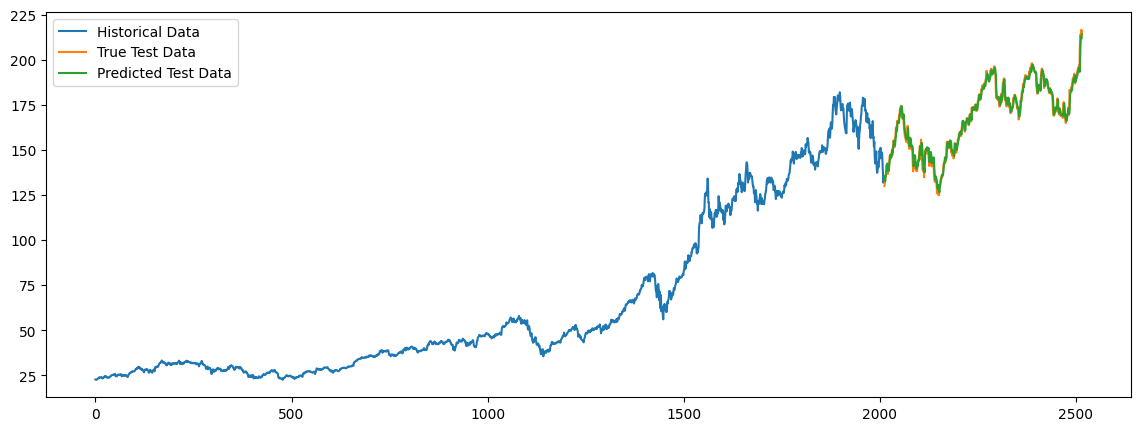

In [47]:
# 绘制结果
historical_data = data[:train_size].flatten()
test_data = data[train_size:].flatten()

plt.figure(figsize=(14, 5))
plt.plot(np.arange(len(historical_data)), historical_data, label='Historical Data')
plt.plot(np.arange(len(historical_data), len(historical_data) + len(test_data)), y_test.flatten(), label='True Test Data')
plt.plot(np.arange(len(historical_data), len(historical_data) + len(test_data)), test_predictions.flatten(), label='Predicted Test Data')
plt.legend()
plt.show()